In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import matplotlib
import random as rd
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
import itertools as it
import seaborn as sn
import scipy as sp

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
def count_permutationlist(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(len(df)-d+1):
        slice_df = df[i:i+d]
        sort_slice = sorted(slice_df)
        for j in range(d):
            slice_df[slice_df.index(sort_slice[j])] = j
        count_p[perm.index(tuple(slice_df))] += 1
    return count_p
def count_permutation(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(df.size-d+1):
        slice_df = df.copy().iloc[i:i+d]
        sort_slice = slice_df.copy().sort_values()
        for j in range(d):
            slice_df[slice_df[slice_df == sort_slice.iloc[j]].first_valid_index()] =  j
        count_p[perm.index(tuple(slice_df.tolist()))] += 1
    return count_p
def entropy(perm:list):
    allperm = sum(perm)
    ent = 0
    for i in range(len(perm)):
        probability = perm[i]/allperm
        if probability !=0:
            ent -= probability * math.log2(probability)
    return ent

In [3]:
def fun(X, alp: float, beta: float, max_kf: float, trend: float, season: float):
    j = 2
    k = 2
    for i in X[2:]:
        X[i] = (alp * X[i-dt.timedelta(1/24)] + beta * X[i-dt.timedelta(2/24)]) + rd.uniform(-max_kf, max_kf) + trend * j
        if k%(7*24)==0:
            X[i]+=season
        if k%(7*24)==1:
            X[i]-=season
        k+=1
    return X

In [4]:
def walds_martingale(X, sigma, tetta):
    s = np.random.normal(0, np.sqrt(sigma), X.shape[0])  
    z=np.cumsum(s)
    for i in range(len(z)):
        z[i] = np.exp(tetta * z[i] - 0.5 * tetta**2 *i)
    X.values = z
    return X
def random_walk(X, noise):
    X[0] = 0
    X[1] = X.index[1]
    for i in X[1:]:
        X[i] = X[i-dt.timedelta(1/24)] + np.random.normal(0, noise)
        #X[i] = X[i-dt.timedelta(1/24)] + rd.uniform(-noise, noise)
    return X

In [5]:
def symmetry_criterion(perm):
    probability = [x/sum(perm) for x in perm]
    probability_deviation = 0
    for i in range(len(perm)//2):
        probability_deviation += (probability[i]-probability[-i-1])    
    return probability_deviation

In [55]:
def equals_criterion(n1,n2,n):
    w1 = n1/n
    w2 = n2/n
    p = (n1+n2)/(2*n)
    z = 0
    if p != 0:
        z = (w1-w2)/(p*(1-p)*(2/n))**0.5
    mod_z = abs(z)
    p_value = 2*(1 - sp.stats.norm.cdf(mod_z))
    return z,p_value

In [56]:
def multiply_equals_criterion(permutations: list, alpha:float=0.05, method:str="hs"):
    p_list = []
    for pair_index in range(len(permutations)//2):
        statistic, p_value = equals_criterion(permutations[pair_index],permutations[-1-pair_index],sum(permutations))
        p_list.append(p_value)
    return sm.stats.multipletests(p_list, alpha, method)

In [8]:
def Smirnov_criterion(df, d, reliability = 0.95):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    tau_max = 0
    tau = 0
    for i in range(df.size-d+1):
        slice_df = df.copy().iloc[i:i+d]
        sort_slice = slice_df.copy().sort_values()
        for j in range(d):
            slice_df[slice_df[slice_df == sort_slice.iloc[j]].first_valid_index()] =  j
        count_p[perm.index(tuple(slice_df.tolist()))] += 1
        tau = -sum(count_p[:len(perm)//2])+sum(count_p[len(perm)//2+1:])
        tau_max = max(abs(tau), tau_max)
    if (df.size+2/3)**(1/2) * 1.96 <= tau_max:
        return ("NO",tau_max, (df.size+2/3)**(1/2) * 1.96)
    else:
        return ("YES",tau_max, (df.size+2/3)**(1/2) * 1.96)
            

In [9]:
datelist = pd.date_range(start='29/06/2023 00:00:00', end='29/07/2024', freq='H').to_series()
datelist.index = datelist
datelist['29/06/2023 00:00:00'] = 5000.0
datelist['29/06/2023 01:00:00'] = 5015.0

In [10]:
rw1 = random_walk(datelist.copy(), 10)
ts = fun(datelist.copy(), 0.6, 0.4, 10, 2, 0)

In [11]:
perm3_rw1 = count_permutation(rw1, 3)
perm3_ts = count_permutation(ts, 3)
perm4_rw1 = count_permutation(rw1, 4)
perm4_ts = count_permutation(ts, 4)

Эвристическая проверка на симметрию. Проверяем разность вероятностей перестановок. Для симметричных распределений они возможно распределены нормально относительно нуля.

In [12]:
symmetry_criterion(perm3_rw1)

-0.011049142376091795

In [13]:
symmetry_criterion(perm4_rw1)

-0.02167964639023365

In [14]:
symmetry_criterion(perm3_ts)

0.543723034831106

In [15]:
symmetry_criterion(perm4_ts)

0.5678804462218481

In [11]:
datelist1 = pd.date_range(start='29/06/2023 00:00:00', end='29/07/2023', freq='H').to_series()
datelist1.index = datelist1
datelist1['29/06/2023 00:00:00'] = 5000.0
datelist1['29/06/2023 01:00:00'] = 5015.0

In [17]:
sym_cr_rw3 = []
sym_cr_rw4 = []
sym_cr_ts3 = []
sym_cr_ts4 = []
for i in range(10):
    print(i)
    rw2 = random_walk(datelist1.copy(), 10)
    ts2 = fun(datelist1.copy(), 0.6, 0.4, 10, 2, 0)
    perm3_rw2 = count_permutation(rw2, 3)
    sym_cr_rw3.append(symmetry_criterion(perm3_rw2))
    perm3_ts2 = count_permutation(ts2, 3)
    sym_cr_ts3.append(symmetry_criterion(perm3_ts2))
    perm4_rw2 = count_permutation(rw2, 4)
    sym_cr_rw4.append(symmetry_criterion(perm4_rw2))
    perm4_ts2 = count_permutation(ts2, 4)
    sym_cr_ts4.append(symmetry_criterion(perm4_ts2))

0
1
2
3
4
5
6
7
8
9


In [18]:
print(min(sym_cr_rw3), max(sym_cr_rw3))

-0.02920723226703756 0.06815020862308761


In [20]:
print(min(sym_cr_rw4), max(sym_cr_rw4))

-0.12256267409470753 0.11142061281337047


In [21]:
print(min(sym_cr_ts3), max(sym_cr_ts3))

0.47426981919332406 0.5994436717663423


In [22]:
print(min(sym_cr_ts4), max(sym_cr_ts4))

0.4958217270194986 0.6211699164345402


In [23]:
sym_cr_rw3 = []
for i in range(1000):
    print(i)
    rw2 = random_walk(datelist1.copy(), 10)
    perm3_rw2 = count_permutation(rw2, 3)
    sym_cr_rw3.append(symmetry_criterion(perm3_rw2))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(array([  1.,  10.,  33., 118., 212., 223., 232., 112.,  47.,  12.]),
 array([-0.17663421, -0.14520167, -0.11376912, -0.08233658, -0.05090403,
        -0.01947149,  0.01196106,  0.0433936 ,  0.07482615,  0.10625869,
         0.13769124]),
 <BarContainer object of 10 artists>)

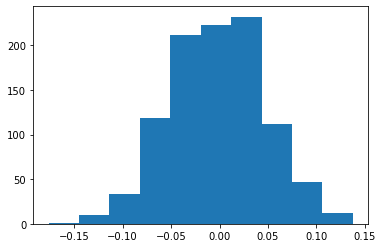

In [24]:
plt.hist(sym_cr_rw3)

Похоже, но не доказуемо

In [25]:
sym_cr_ts3 = []
for i in range(1000):
    if i%100 == 0:
        print(i)
    ts2 = fun(datelist1.copy(), 0.6, 0.4, 10, 2, 0)
    perm3_ts2 = count_permutation(ts2, 3)
    sym_cr_ts3.append(symmetry_criterion(perm3_ts2))

0
100
200
300
400
500
600
700
800
900


(array([ 10.,  18.,  96., 164., 221., 236., 154.,  81.,  12.,   8.]),
 array([0.44367177, 0.46536857, 0.48706537, 0.50876217, 0.53045897,
        0.55215577, 0.57385257, 0.59554937, 0.61724618, 0.63894298,
        0.66063978]),
 <BarContainer object of 10 artists>)

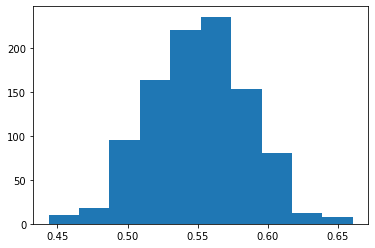

In [26]:
plt.hist(sym_cr_ts3)

Для несимметричных похоже на нормальное относительно 0.55 (для модуля). Неочевидно и не доказуемо.

(array([  1.,   8.,  21.,  65., 144., 202., 202., 194., 104.,  45.,  13.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         10.,  39., 144., 292., 286., 168.,  50.,  11.]),
 array([-0.17663421, -0.14872508, -0.12081595, -0.09290682, -0.06499768,
        -0.03708855, -0.00917942,  0.01872972,  0.04663885,  0.07454798,
         0.10245712,  0.13036625,  0.15827538,  0.18618452,  0.21409365,
         0.24200278,  0.26991191,  0.29782105,  0.32573018,  0.35363931,
         0.38154845,  0.40945758,  0.43736671,  0.46527585,  0.49318498,
         0.52109411,  0.54900325,  0.57691238,  0.60482151,  0.63273064,
         0.66063978]),
 <BarContainer object of 30 artists>)

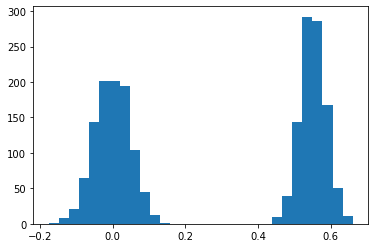

In [30]:
plt.hist(sym_cr_ts3, bins=30)

In [31]:
sym_cr_ts3 = []
for i in range(1000):
    if i%100 == 0:
        print(i)
    a = rd.uniform(0,1)
    ts2 = fun(datelist1.copy(), a, 1-a, 10, rd.uniform(-2,2), 0)
    perm3_ts2 = count_permutation(ts2, 3)
    sym_cr_ts3.append(symmetry_criterion(perm3_ts2))

0
100
200
300
400
500
600
700
800
900


In [ ]:
plt.hist(sym_cr_ts3, bins=30)

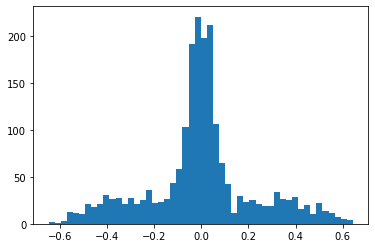

In [32]:
sym_cr = sym_cr_ts3.copy()
sym_cr.extend(sym_cr_rw3)
plt.hist(sym_cr, bins=50)
plt.show()

Так выглядит общее распределение статистики. Попробуем преобразовать критерий Смирнова под наше категориальное распределение

In [26]:
Smirnov_criterion(rw1, 4)

('YES', 172, 191.09413666218717)

<Axes: >

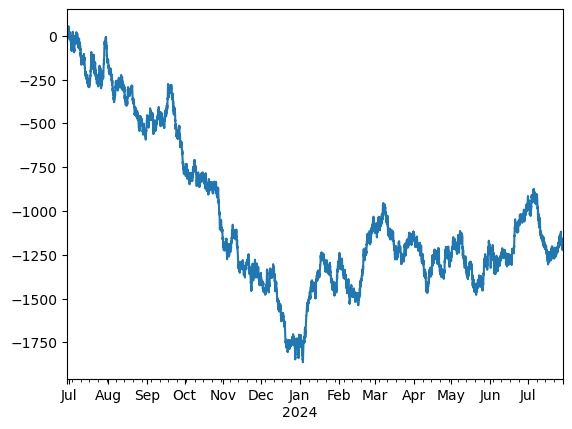

In [20]:
rw1.plot()

In [27]:
sym_cr_rw4 = []
for i in range(1000):
    rw2 = random_walk(datelist1.copy(), 10)
    sym_cr_rw4.append(list(Smirnov_criterion(rw2, 4)))
sym_cr_rw4 = pd.DataFrame(sym_cr_rw4)

In [34]:
sym_cr_rw4.columns = ['Sym',"tau","tau_crit"]

In [37]:
sym_cr_rw4[sym_cr_rw4.Sym == "YES"]

,Sym,tau,tau_crit
0,YES,51,52.653154
1,YES,39,52.653154
3,YES,28,52.653154
4,YES,35,52.653154
7,YES,27,52.653154
...,...,...,...
994,YES,43,52.653154
995,YES,32,52.653154
997,YES,23,52.653154
998,YES,32,52.653154


Имеем плохую способность определять наше симметричное распределение. Проверяем как работает наш критерий симметричности, основанный на множественной проверки гипотез о равенстве вероятностей.

In [22]:
rw = random_walk(datelist.copy(), 10)

In [23]:
perm = count_permutation(rw, 3)

<BarContainer object of 6 artists>

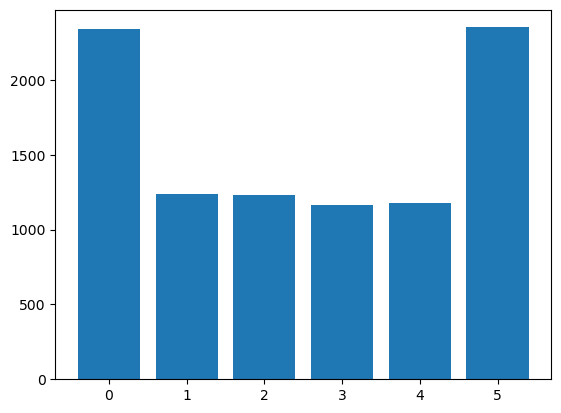

In [24]:
plt.bar(range(len(perm)),perm)

In [34]:
equals_criterion(perm[0],perm[5],sum(perm))

(-0.2018967566386016, 0.20999935942341091)

In [35]:
equals_criterion(perm[1],perm[4],sum(perm))

(1.306085028569602, 0.047880910918024266)

In [36]:
equals_criterion(perm[2],perm[3],sum(perm))

(1.3332897779635697, 0.04560918172637152)

In [37]:
equals_criterion(perm[0],perm[1],sum(perm))

(20.41094274236331, 0.0)

In [38]:
equals_criterion(perm[0],perm[4],sum(perm))

(21.66495364533908, 0.0)

In [39]:
multiply_equals_criterion(perm)

(array([False, False, False]),
 array([0.20999936, 0.13068183, 0.13068183]),
 0.016952427508441503,
 0.016666666666666666)

In [40]:
perm = count_permutation(rw, 4)

<BarContainer object of 24 artists>

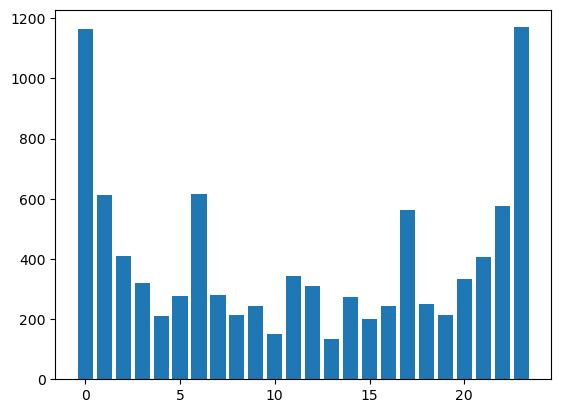

In [41]:
plt.bar(range(len(perm)),perm)

In [42]:
multiply_equals_criterion(perm)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([0.50894728, 0.38385839, 0.50894728, 0.49928078, 0.50894728,
        0.38122767, 0.27102657, 0.28746054, 0.49928078, 0.368589  ,
        0.41034361, 0.368589  ]),
 0.004265318777560645,
 0.004166666666666667)

In [43]:
ts = fun(datelist.copy(), 0.6, 0.4, 5, np.random.normal(0,2), 0)

In [44]:
ts_perm = count_permutation(ts, 4)

<BarContainer object of 24 artists>

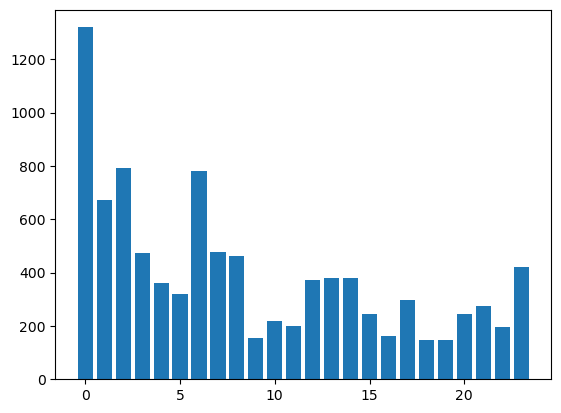

In [45]:
plt.bar(range(len(ts_perm)),ts_perm)

In [46]:
multiply_equals_criterion(ts_perm)

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.66533454e-16, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.47114609e-12, 1.54876112e-13]),
 0.004265318777560645,
 0.004166666666666667)

In [57]:
not_simmetry = []
for i in range(1000):
    if i%100 == 0:
        print(i)
    rw2 = random_walk(datelist1.copy(), 10)
    ts_perm = count_permutation(rw2, 3)
    cr = multiply_equals_criterion(ts_perm)
    if sum(cr[0]) != 0:
        print(cr)
        not_simmetry.append([rw2,ts_perm])

0


D:\Programs\Anac\lib\site-packages\statsmodels\stats\multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


(array([ True, False, False]), array([0.00132425, 0.64507947, 0.64507947]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.04186575, 0.93965935, 0.93965935]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.03938725, 0.75904575, 0.75904575]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.00280503, 0.76120083, 0.76120083]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.04547714, 0.7279452 , 0.7279452 ]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.00511079, 0.93858083, 0.93858083]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.03222404, 0.51819495, 0.51819495]), 0.016952427508441503, 0.016666666666666666)
(array([False,  True,  True]), array([0.1649271 , 0.03674972, 0.03674972]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.

500
(array([ True, False, False]), array([0.02267855, 0.62334688, 0.62334688]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.00686614, 0.73411127, 0.73411127]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.00246927, 0.05066208, 0.05066208]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.0087774 , 0.10408235, 0.10408235]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.02726538, 0.26646786, 0.26646786]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.00200132, 0.96075447, 0.96075447]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.04725885, 0.59064222, 0.59064222]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([8.20983685e-04, 9.38023834e-01, 9.38023834e-01]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, Fa

(array([ True, False, False]), array([0.01066509, 0.82621993, 0.82621993]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.01035957, 0.25950488, 0.25950488]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([4.85206973e-07, 7.21414668e-01, 7.21414668e-01]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.01167974, 0.08359855, 0.08359855]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([5.53878199e-04, 8.40358818e-01, 8.40358818e-01]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.00092433, 0.77322128, 0.77322128]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([2.68245287e-04, 9.95605191e-01, 9.95605191e-01]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.00097493, 0.86377811, 0.86377811]), 0.016952427508441503, 0.016666666666666666)
(arr

In [58]:
len(not_simmetry)/1000

0.153

In [59]:
simmetry = []
for i in range(1000):
    if i%100 == 0:
        print(i)
    alp = np.random.rand()
    ts = fun(datelist1.copy(), alp, 1-alp, np.random.uniform(1,10), np.random.normal(0,2), 0)
    ts_perm = count_permutation(ts, 3)
    cr = multiply_equals_criterion(ts_perm)
    if sum(cr[0]) == 0:
        print(cr)
        simmetry.append([ts,ts_perm])

0
(array([False, False, False]), array([0.10149758, 0.10149758, 0.10149758]), 0.016952427508441503, 0.016666666666666666)
(array([False, False, False]), array([1.        , 0.55726284, 0.55726284]), 0.016952427508441503, 0.016666666666666666)
(array([False, False, False]), array([0.95097106, 0.95097106, 0.95097106]), 0.016952427508441503, 0.016666666666666666)
(array([False, False, False]), array([0.54705152, 0.11135869, 0.11135869]), 0.016952427508441503, 0.016666666666666666)
(array([False, False, False]), array([0.6848746, 0.6848746, 0.6848746]), 0.016952427508441503, 0.016666666666666666)
(array([False, False, False]), array([0.35000472, 0.35000472, 0.35000472]), 0.016952427508441503, 0.016666666666666666)
(array([False, False, False]), array([0.46554167, 0.97167656, 0.97167656]), 0.016952427508441503, 0.016666666666666666)
(array([False, False, False]), array([0.20909504, 1.        , 0.99649792]), 0.016952427508441503, 0.016666666666666666)
(array([False, False, False]), array([0.6

In [62]:
len(simmetry)/1000

0.063

In [60]:
not_simmetry = []
for i in range(200):
    if i%500 == 0:
        print(i)
    rw2 = random_walk(datelist.copy(), 10)
    ts_perm = count_permutation(rw2, 3)
    cr = multiply_equals_criterion(ts_perm)
    if sum(cr[0]) != 0:
        print(cr)
        not_simmetry.append([rw2,ts_perm])

0
(array([ True,  True,  True]), array([0.00016417, 0.03520035, 0.03520035]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.00708606, 0.43047661, 0.43047661]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.03669518, 0.95702742, 0.95702742]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.01714747, 0.49084162, 0.49084162]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.01266304, 0.82427733, 0.82427733]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.0109091 , 0.98468824, 0.98468824]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([3.17440843e-04, 9.97237045e-01, 9.97237045e-01]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, False]), array([0.01711324, 0.07111308, 0.07111308]), 0.016952427508441503, 0.016666666666666666)
(array([ True, False, Fals

KeyboardInterrupt: 

In [61]:
len(not_simmetry)/i

0.15254237288135594